In [269]:
import warnings
warnings.filterwarnings('ignore')

# 背景

定价优化是数据科学能够提供巨大价值的另一个领域。此次分析的目标是评估网站上运行的定价测试是否成功。

在分析中，需要重点关注用户细分，并提供有关不同行为用户群体的见解，以及可能发现的其他有价值的洞察。

XYZ公司销售一款软件，定价为 39。由于收入增长停滞不前，产品副总裁决定进行一次提价测试。她希望通过提高价格来增加收入。在实验中，66%的用户看到的是旧价格（39），而随机抽取的33%的用户看到的是更高的价格（59）。

测试已经运行了一段时间，产品副总裁希望了解测试的结果，并考虑是否应该将所有用户的价格都提高。

她特别想知道以下问题的答案：

1. 公司应该将软件定价为39 还是 59？
2. 产品副总裁希望全面了解用户行为，特别是关注可以提高转化率的可操作性见解。你在数据中发现了哪些主要的见解？
3. **[额外问题]** 产品副总裁认为测试运行时间过长，她应该在更短的时间内就能得到具有统计显著性的结果。你是否同意她的直觉？你会在测试运行多少天后停止测试？请解释原因。

# 导入数据

In [270]:
# 导入必备的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

导入数据集：

In [271]:
user_data = pd.read_csv("./../dataset/06. Pricing_Test/user_table.csv")

In [272]:
user_data.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [273]:
test_data = pd.read_csv("./../dataset/06. Pricing_Test/test_results.csv", parse_dates=['timestamp'])

In [274]:
test_data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


查看一下缺失值的情况：

In [275]:
user_data.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [276]:
test_data.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

都不存在着缺失值。

# 数据处理

查看一下其他的信息：

In [277]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [278]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


从 info() 的结果来看，user_data 和 test_data 中的 user_id 数量是不匹配的：

- user_data 中的 user_id 数量是 275,616。
- test_data 中的 user_id 数量是 316,800。

这可能意味着：

- 不一致的用户记录：test_data 中的部分 user_id 在 user_data 中没有对应的记录，反之亦然。
- 重复或缺失的记录：一种可能性是其中一个数据集存在重复的 user_id，或者另一个数据集中有缺失的 user_id。

首先确定一下是否存在着重复值：

In [279]:
# 检查 user_data 中的重复 user_id
duplicate_user_ids_in_user_data = user_data[user_data.duplicated(subset='user_id', keep=False)]
num_duplicates_user_data = duplicate_user_ids_in_user_data['user_id'].nunique()

# 检查 test_data 中的重复 user_id
duplicate_user_ids_in_test_data = test_data[test_data.duplicated(subset='user_id', keep=False)]
num_duplicates_test_data = duplicate_user_ids_in_test_data['user_id'].nunique()

In [280]:
num_duplicates_user_data, num_duplicates_test_data

(0, 0)

可以认为两个数据集中都不存在着重复值。

接着查看的是数据集的重叠部分，各自的独特部分：

In [281]:
# 查找 user_data 和 test_data 中重叠的和不重叠的 user_id

# 提取两个数据集中所有的 user_id
user_ids_user_data = set(user_data['user_id'])
user_ids_test_data = set(test_data['user_id'])

# 计算重叠的 user_id 数量
overlap_user_ids = user_ids_user_data & user_ids_test_data
num_overlap_user_ids = len(overlap_user_ids)

# 计算 user_data 中不重叠的 user_id 数量
num_non_overlap_user_data = len(user_ids_user_data - user_ids_test_data)

# 计算 test_data 中不重叠的 user_id 数量
num_non_overlap_test_data = len(user_ids_test_data - user_ids_user_data)

In [282]:
num_overlap_user_ids, num_non_overlap_user_data, num_non_overlap_test_data

(275616, 0, 41184)

上述的结果指出：

1. **重叠的 `user_id` 数量**: 275,616  
   这表示在两个数据集中共有 275,616 个 `user_id` 是相同的。

2. **`user_data` 中不重叠的 `user_id` 数量**: 0  
   这表示 `user_data` 中的所有 `user_id` 都出现在 `test_data` 中。

3. **`test_data` 中不重叠的 `user_id` 数量**: 41,184  
   这表示 `test_data` 中有 41,184 个 `user_id` 没有出现在 `user_data` 中。

**结论**

- **完全重叠**：`user_data` 中的所有用户都存在于 `test_data` 中。
- **额外的用户**：`test_data` 中有 41,184 个用户没有在 `user_data` 中找到。

这可能意味着 `test_data` 中包含了一些没有位置信息（city、country 等）的用户，或者这些用户在 `user_data` 中的记录丢失了。

In [283]:
# 提取出 test_data 中不在 user_data 中的 user_id 对应的记录
unique_test_data = test_data[test_data['user_id'].isin(user_ids_test_data - user_ids_user_data)]

开始进行合并：

In [284]:
# merge test_results with user_table
data = pd.merge(left=test_data, right=user_data, how='left', on='user_id')

In [285]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [286]:
# Problem with the data: test and price not match
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

这个结果显示了在价格测试中，不同用户（user_id）对不同价格（price）的反应。具体数据如下：

- 用户 `user_id` 为 `0` 的情况下，价格为 `39` 时，测试结果为 `202517`。同样，价格为 `59` 时，测试结果为 `210`。
- 用户 `user_id` 为 `1` 的情况下，价格为 `39` 时，测试结果为 `155`。同样，价格为 `59` 时，测试结果为 `113918`。

这是存在着问题的，如果测试设计中原价应该是 39，而新价格应该是 59，那么测试数据应当按照这一标准来记录。

In [287]:
# 由于占比非常的低，所以采用直接移除来进行处理
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [288]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


现在完成了移除，接着生成一个新的变量，利润：

In [289]:
data['revenue'] = data['converted'] * data['price']

In [290]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


查看一下缺失值的分布情况：

In [291]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

# 可视化

我们需要可视化test 0和test 1中的不同特征的分布情况，这些特征的分布应该是近似的，如果存在着较大的差异，则可以视作进行随机抽样的时候出现了问题。

**source**

In [292]:
# source
source = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True))# .unstack()

In [293]:
source

test                 
0     direct_traffic     0.191154
      ads-google         0.186873
      ads_facebook       0.168253
      ads_other          0.095083
      seo-google         0.074502
      ads-bing           0.072014
      seo_facebook       0.066468
      friend_referral    0.064790
      seo-other          0.029030
      ads-yahoo          0.023761
      seo-yahoo          0.021509
      seo-bing           0.006562
1     direct_traffic     0.189259
      ads-google         0.188706
      ads_facebook       0.169253
      ads_other          0.092786
      ads-bing           0.072394
      seo-google         0.070753
      seo_facebook       0.067786
      friend_referral    0.066337
      seo-other          0.029539
      ads-yahoo          0.024219
      seo-yahoo          0.021814
      seo-bing           0.007154
Name: source, dtype: float64

In [294]:
source = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()

In [295]:
source

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


接着进行可视化：

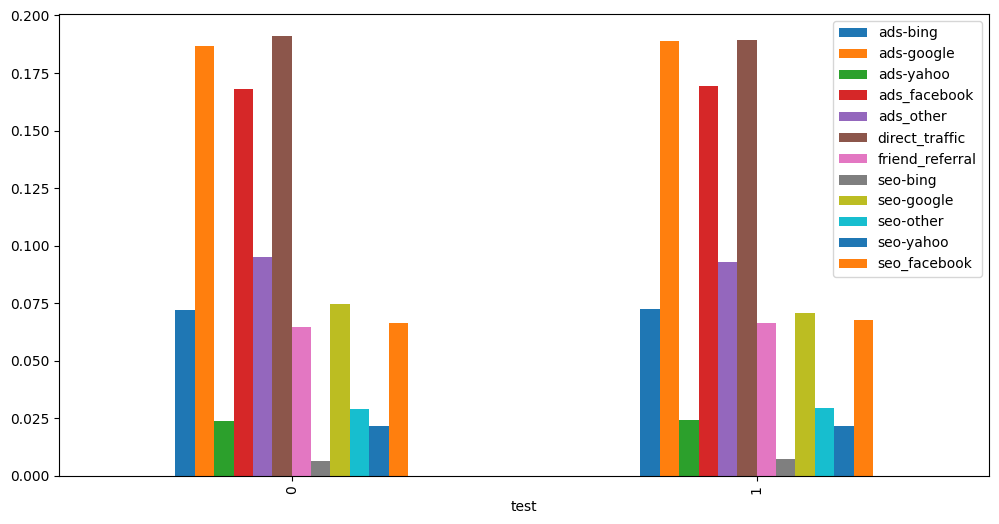

In [296]:
fig, ax = plt.subplots(figsize=(12, 6))
source.plot(kind='bar', ax=ax)
plt.show()

从可视化的结果来看，不同的来源的在两个test上的分布是基本一致的。

In [297]:
# Visualization of source
count = data[['source', 'test', 'revenue']].groupby(['source', 'test']).count().reset_index()

In [298]:
count

,source,test,revenue
0,ads-bing,0,14584
1,ads-bing,1,8247
2,ads-google,0,37845
3,ads-google,1,21497
4,ads-yahoo,0,4812
5,ads-yahoo,1,2759
6,ads_facebook,0,34074
7,ads_facebook,1,19281
8,ads_other,0,19256
9,ads_other,1,10570


接着采用相对频率：

In [299]:
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

In [300]:
count

,source,test,revenue
0,ads-bing,0,0.072014
1,ads-bing,1,0.072394
2,ads-google,0,0.186873
3,ads-google,1,0.188706
4,ads-yahoo,0,0.023761
5,ads-yahoo,1,0.024219
6,ads_facebook,0,0.168253
7,ads_facebook,1,0.169253
8,ads_other,0,0.095083
9,ads_other,1,0.092786


采用相对频率是为了确保公平。

不同的测试组可能包含不同数量的记录。如果直接比较记录数（如 revenue 列的计数）可能会导致不公平的比较，因为测试组的大小不同。通过计算相对频率（即每个 source 在测试组中的比例），可以消除这些差异，使得不同测试组的比较更加公正。

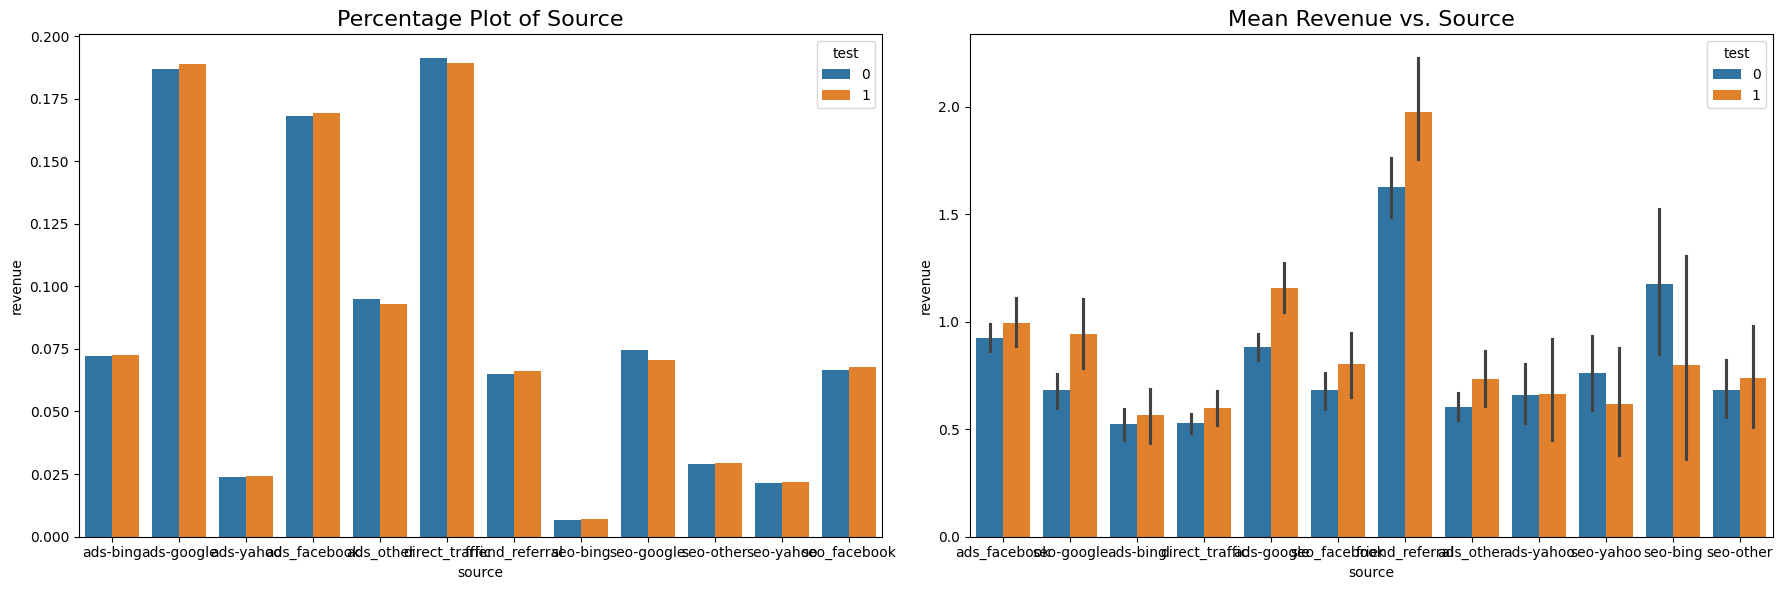

In [301]:
# hue='test' 用于在条形图中区分不同的 test 组（test0 和 test1）
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()

plt.show()

**Device**

查看硬件的特征的分布：

In [302]:
# Check randominess
device = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()

In [303]:
device

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


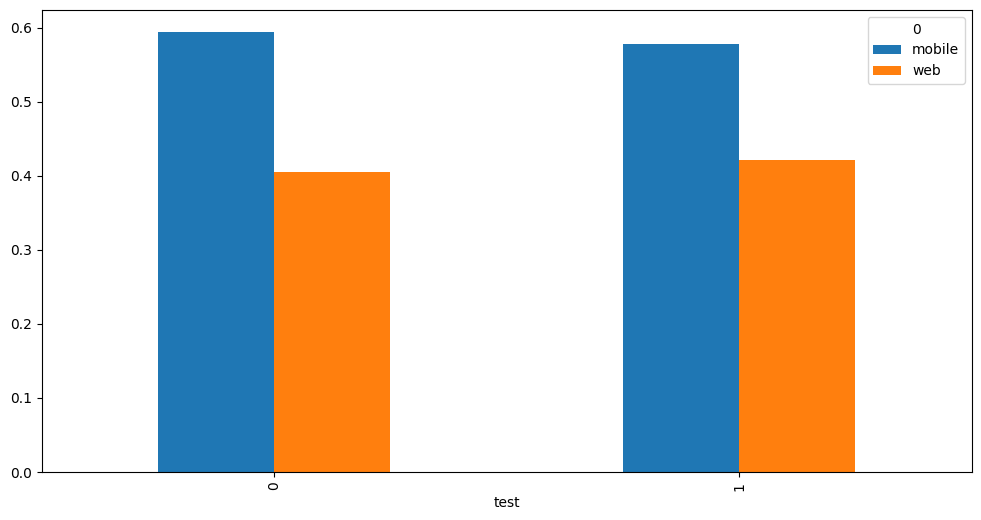

In [304]:
fig, ax = plt.subplots(figsize=(12, 6))
device.plot(kind='bar', ax=ax)
plt.show()

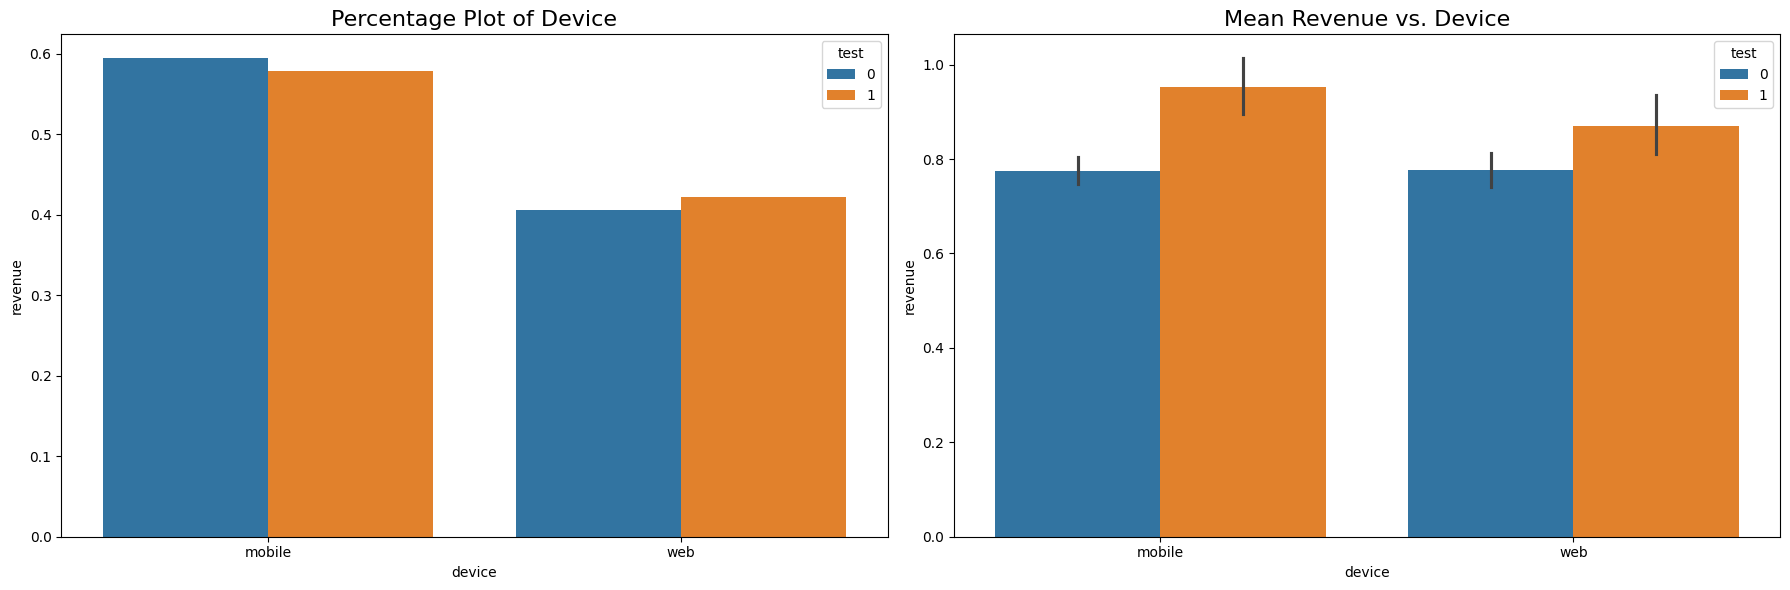

In [305]:
# Visualization of device
count = data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

**操作系统**

In [306]:
# Check randominess
os = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
os

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


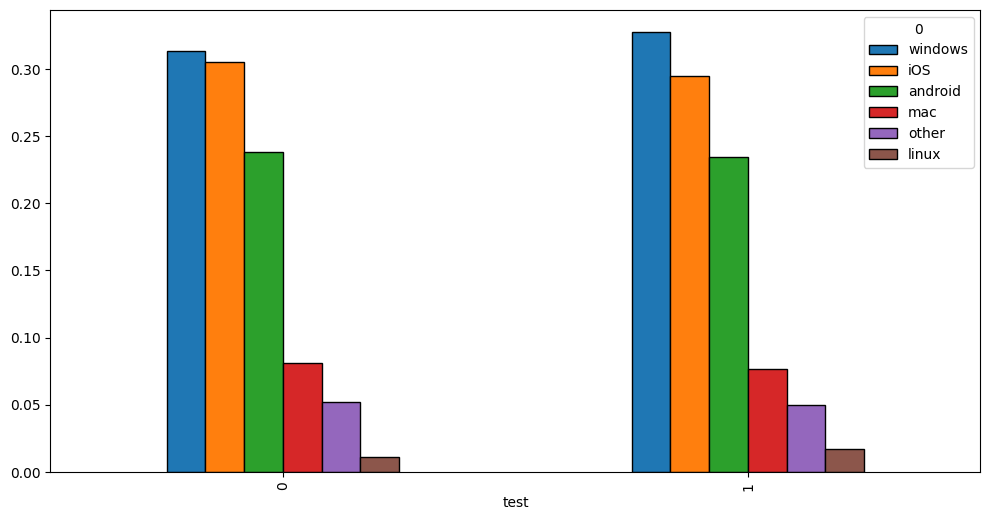

In [307]:
fig, ax = plt.subplots(figsize=(12, 6))
os.plot(kind='bar', ax=ax, edgecolor = 'black')
plt.show()

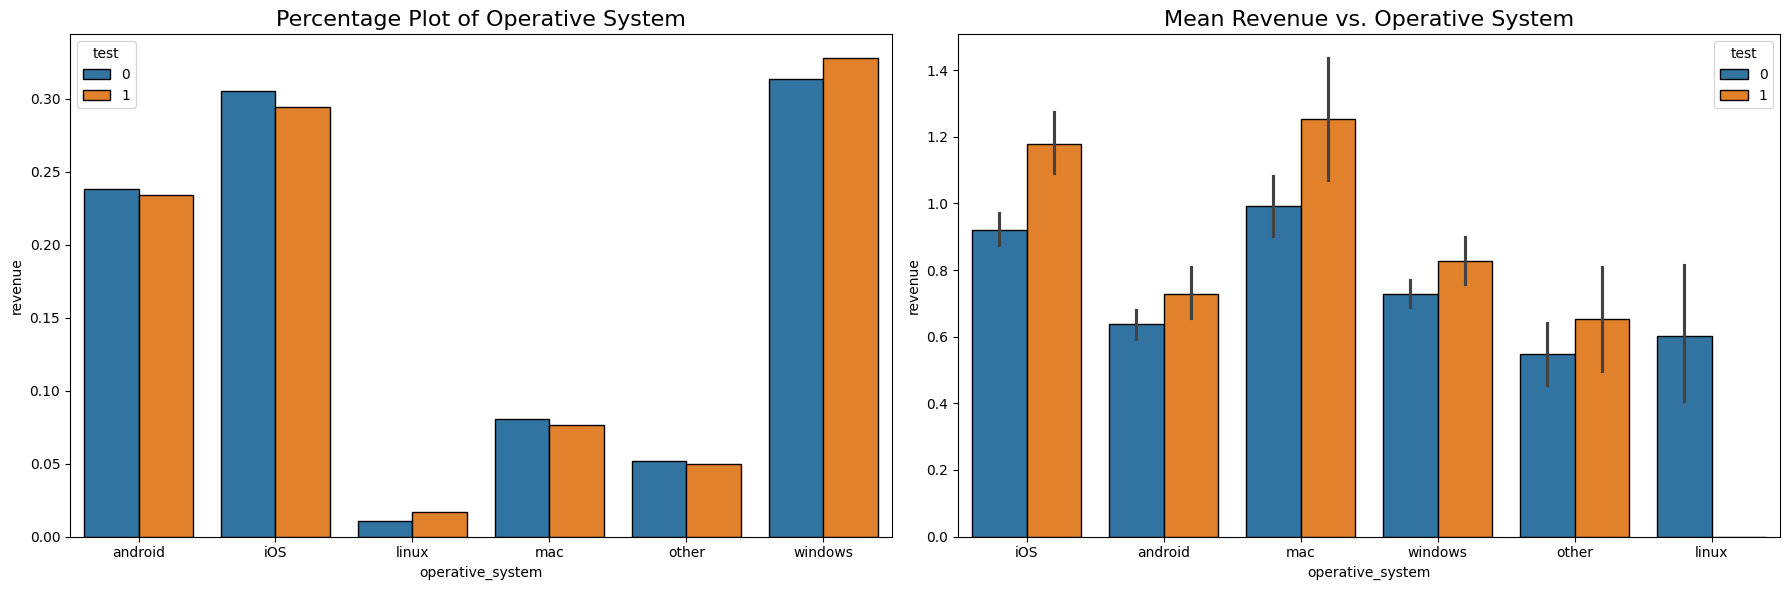

In [308]:
# Visualization of operative system
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0], edgecolor = 'black')  # ax = ax[0] 在这里是用来创建子图的
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=data, ax=ax[1], edgecolor = 'black')
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

# 定价策略

需要进行A/B test分析

In [309]:
# check the conversion rate for A/B test
data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [310]:
# check the revenue for A/B test
data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


从结果来看，虽然价格为39的时候的转换率更高一些，但是并利润却低于了价格为59的时候的利润。

但是需要进行假设性检验。

两个假设：
- $H_0$: 假设涨价前后的利润没有显著差异。即，涨价不会显著改变利润分布。
- $H_1$：假设涨价后利润与原价时的利润有显著差异，即涨价会显著改变利润分布。

假设涨价后利润与原价时的利润有显著差异，即涨价会显著改变利润分布。

In [311]:
from scipy.stats import ttest_ind

In [312]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values

In [313]:
ctr_val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [314]:
exp_val

array([ 0, 59,  0, ...,  0,  0,  0], dtype=int64)

In [315]:
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

TtestResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08, df=186141.738219264)


在进行独立样本 t 检验时，结果显示 t 统计量为 -5.715，p 值为 1.10e-08，自由度为 186141.738。这些结果表明，在比较原价和涨价后的收益时，两个测试组之间的差异是显著的。t 统计量的绝对值较大，指示样本均值之间存在显著的差异，而负值则表明涨价后的平均收益低于原价时的平均收益。

p 值非常小，远远低于通常设定的显著性水平（例如 0.05 或 0.01）。这意味着在零假设（即两个组之间没有显著差异）下，观察到如此极端结果的概率极低。因此，我们可以拒绝零假设，认为涨价对收益的影响是显著的，而不是由于随机波动造成的。

自由度值接近 186,142，表明样本量非常大，这为检验结果的可靠性提供了支持。综合这些结果，可以得出结论：涨价策略导致的收益变化在统计上是显著的，因此可能需要重新评估是否继续实施该策略或调整价格策略以优化收益。

涨价后，利润收益显著下降，表明涨价对收益产生了负面影响。这个结果表明，涨价策略可能导致了客户的流失或减少了销售量，从而导致整体利润的下降。因此，可能需要考虑调整价格策略以优化收益。

这与之前下定的结论存在着矛盾，这里采用该结论，因为之前的结论只是基于平均收益的初步比较，不具有统计意义。

# 用户转换率

**source**

In [316]:
data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


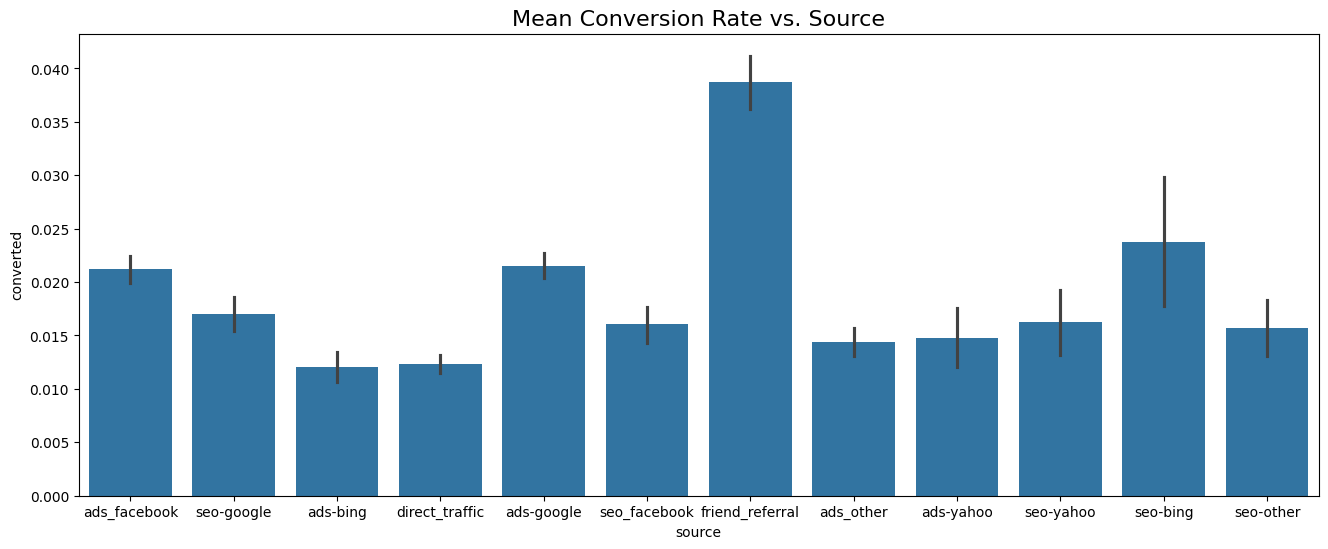

In [317]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

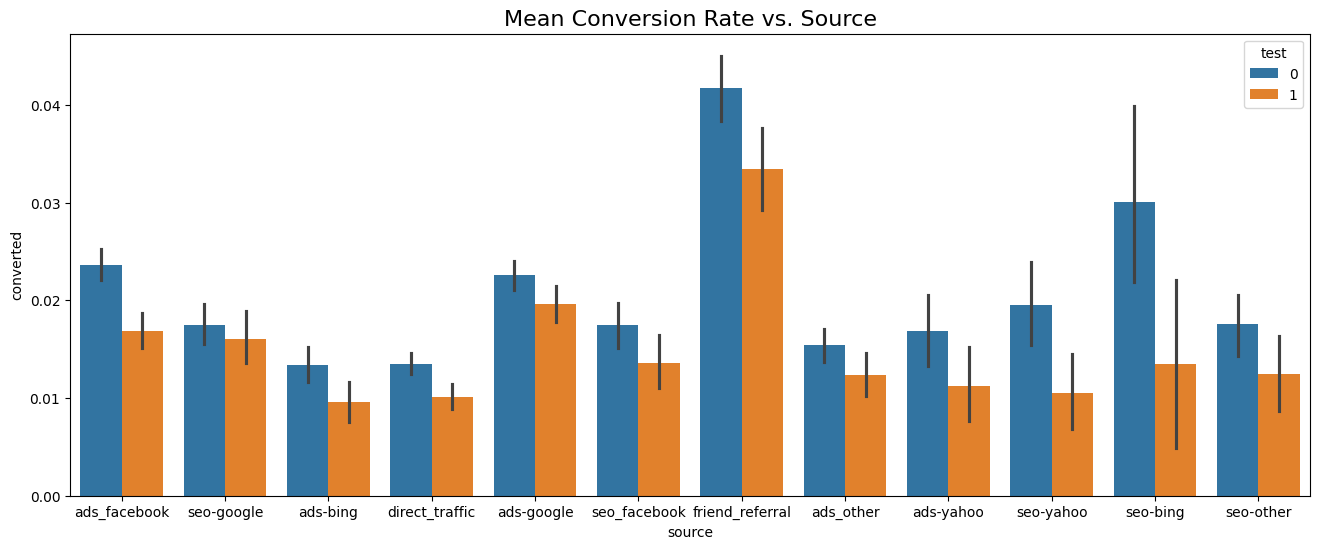

In [318]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

**Device**

In [319]:
data.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


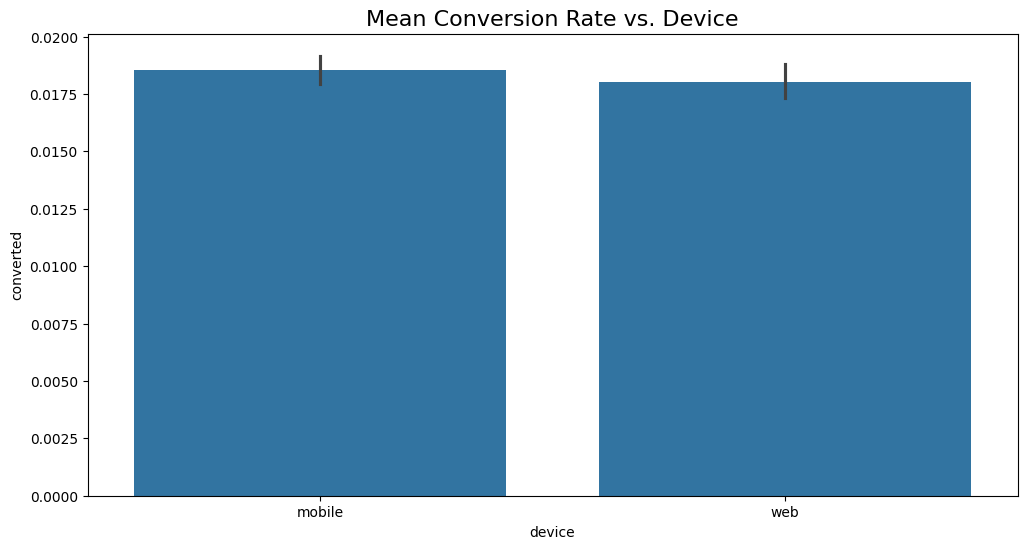

In [320]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

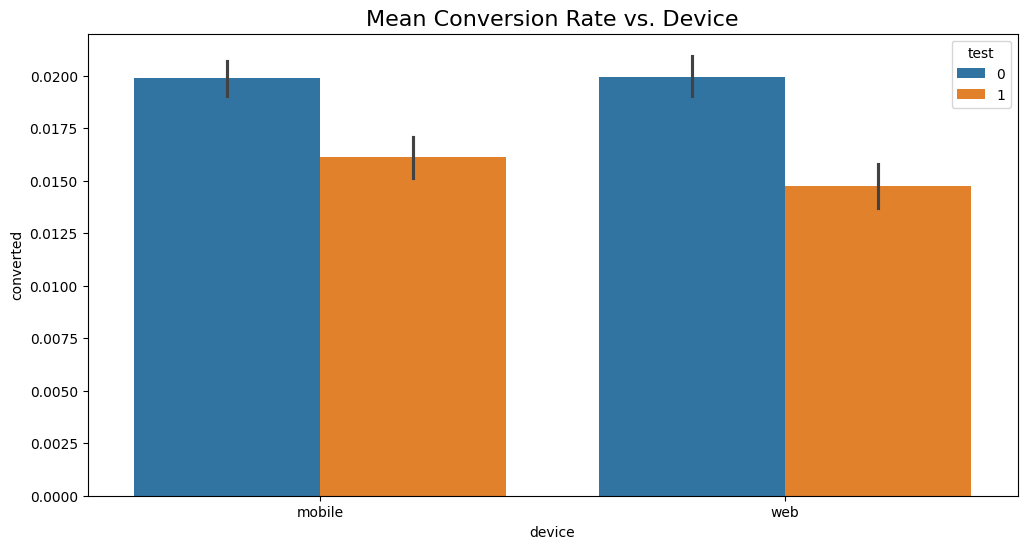

In [321]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

**Operating System**

In [322]:
data.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


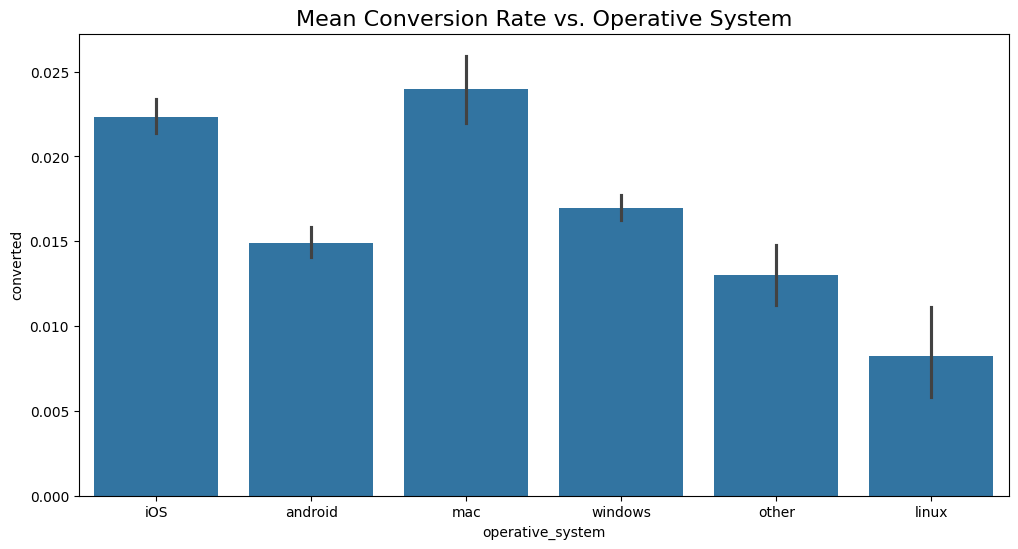

In [323]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

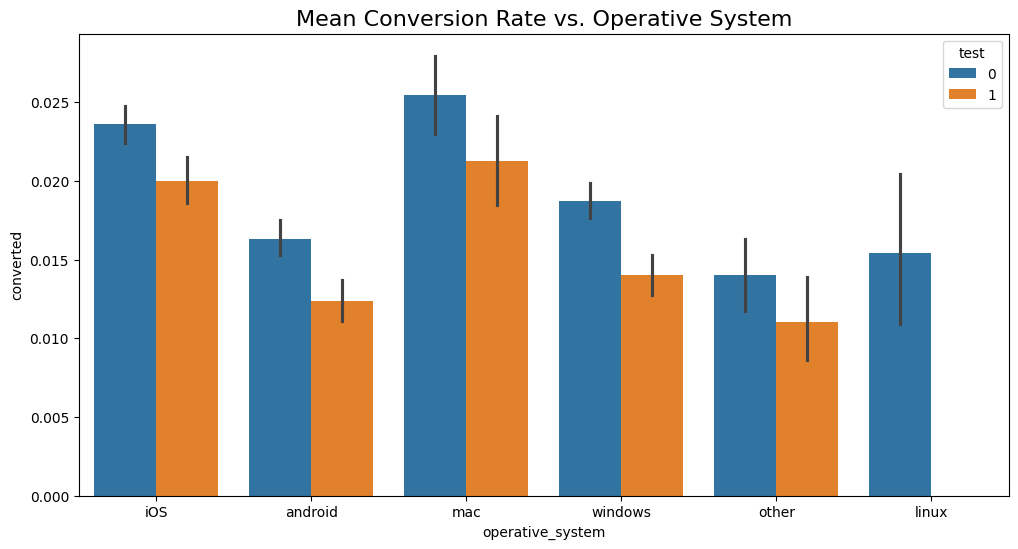

In [324]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

根据上述可视化结果，我们可以轻松得出价格对转化率有显著影响的结论。然而，除了价格之外，还有其他因素可能影响转化率。

1. **来源（Source）**:
   - 通过朋友推荐的用户具有更高的转化率。

2. **设备（Device）**:
   - 设备的影响不显著。

3. **操作系统（Operative System）**:
   - 使用 Mac 和 iOS 的用户具有更高的转化率。